<a href="https://colab.research.google.com/github/gopikasb/AIESI/blob/master/layout_parser_extract_tables_from_imagedoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U layoutparser

     |████████████████████████████████| 19.2 MB 459 kB/s 
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 596 kB 53.8 MB/s 
     |████████████████████████████████| 5.6 MB 19.1 MB/s 
     |████████████████████████████████| 4.3 MB 40.0 MB/s 
     |████████████████████████████████| 139 kB 47.6 MB/s 
     |████████████████████████████████| 3.6 MB 53.8 MB/s 
  Created wheel for pdfplumber: filename=pdfplumber-0.6.0-py3-none-any.whl size=33688 sha256=6ea7645e19079700d282efb5863fb79eab111ce184d23ef9dc65aca6f95e7bbd
  Stored in directory: /root/.cache/pip/wheels/58/56/fe/2e93d842ffa9ea97746c1ab253d43502ed61c0689361a0224e
Successfully built pdfplumber
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [11]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2'


  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.5) to /tmp/pip-install-o4zfliaz/detectron2_0b3c2322a3054954b7f70a9772013760
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-install-o4zfliaz/detectron2_0b3c2322a3054954b7f70a9772013760
  Running command git checkout -q 82a57ce0b70057685962b352535147d9a8118578
     |████████████████████████████████| 49 kB 2.7 MB/s 
     |████████████████████████████████| 74 kB 2.3 MB/s 
     |████████████████████████████████| 145 kB 32.4 MB/s 
     |████████████████████████████████| 130 kB 42.6 MB/s 
     |████████████████████████████████| 843 kB 45.5 MB/s 
     |████████████████████████████████| 748 kB 36.5 MB/s 
     |████████████████████████████████| 112 kB 48.1 MB/s 
  Created wheel for detectron2: filename=detectron2-0.5-cp37-cp37m-linux_x86_64.whl size=5351686 sha256=ea24198d68fb43ff98849880d7d111b4d6073b03ed3670a23931759b1023ceec
  Stored in directory: /tmp/pip-ephem-wheel-cache

In [1]:
!pip install layoutparser[ocr]

In [2]:
!git clone https://github.com/Layout-Parser/layout-parser.git

fatal: destination path 'layout-parser' already exists and is not an empty directory.


In [3]:
%cd layout-parser/

/content/layout-parser


In [4]:
import cv2
image = cv2.imread("/content/layout-parser/examples/data/example-table.jpeg")
image = image[..., ::-1]

config.yaml?dl=1: 8.19kB [00:01, 7.58kB/s]
model_final.pth?dl=1: 856MB [00:32, 26.6MB/s]
The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshg

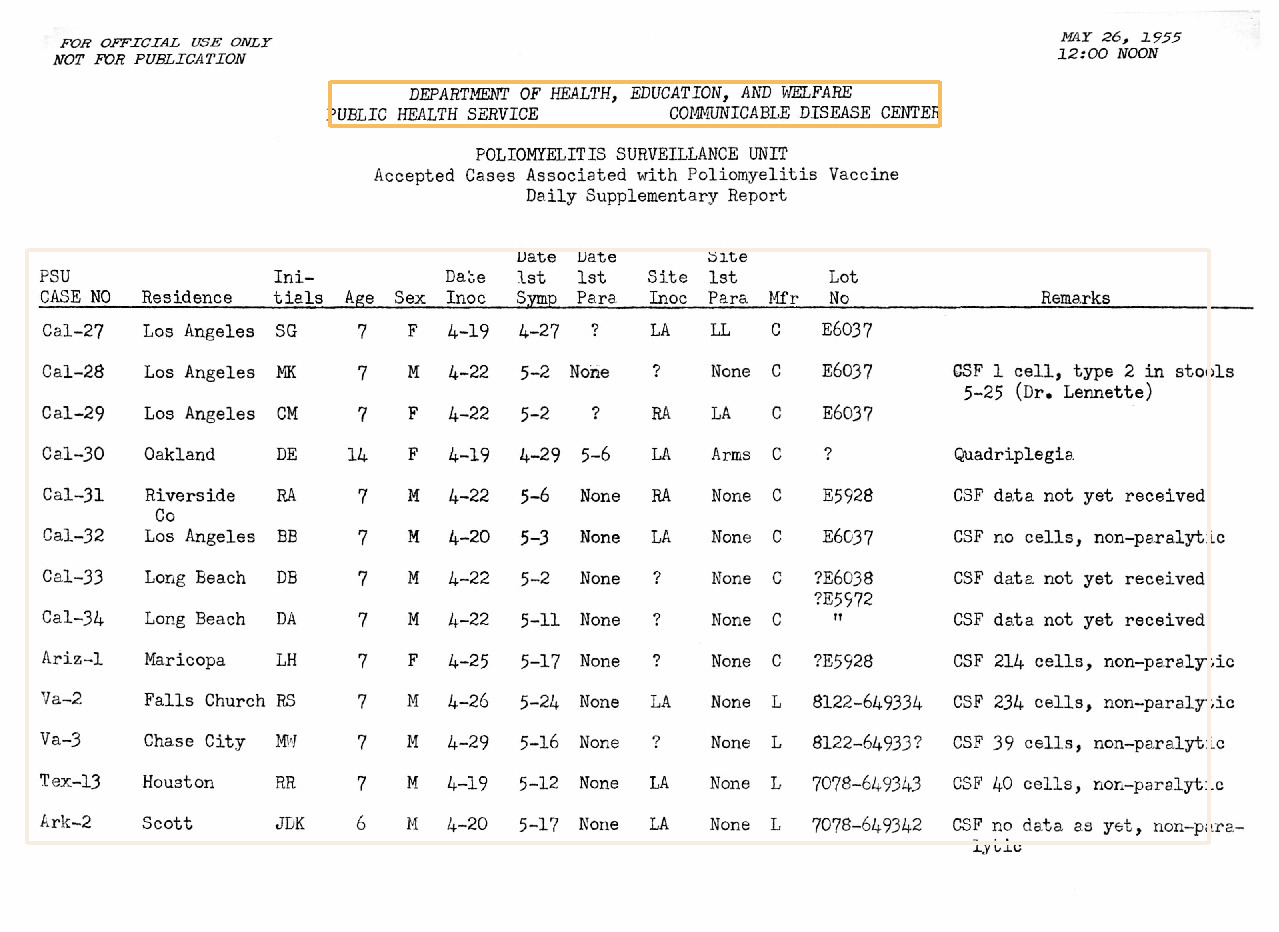

In [5]:
import layoutparser as lp
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout = model.detect(image) # You need to load the image somewhere else, e.g., image = cv2.imread(...)
lp.draw_box(image, layout,)

In [6]:
text_blocks = lp.Layout([b for b in layout if b.type=="Table"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=27.745519638061523, y_1=249.892578125, x_2=1208.8997802734375, y_2=843.3308715820312), text=None, id=None, type=Table, parent=None, next=None, score=0.9762899279594421)], page_data={})

In [7]:
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [8]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [9]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

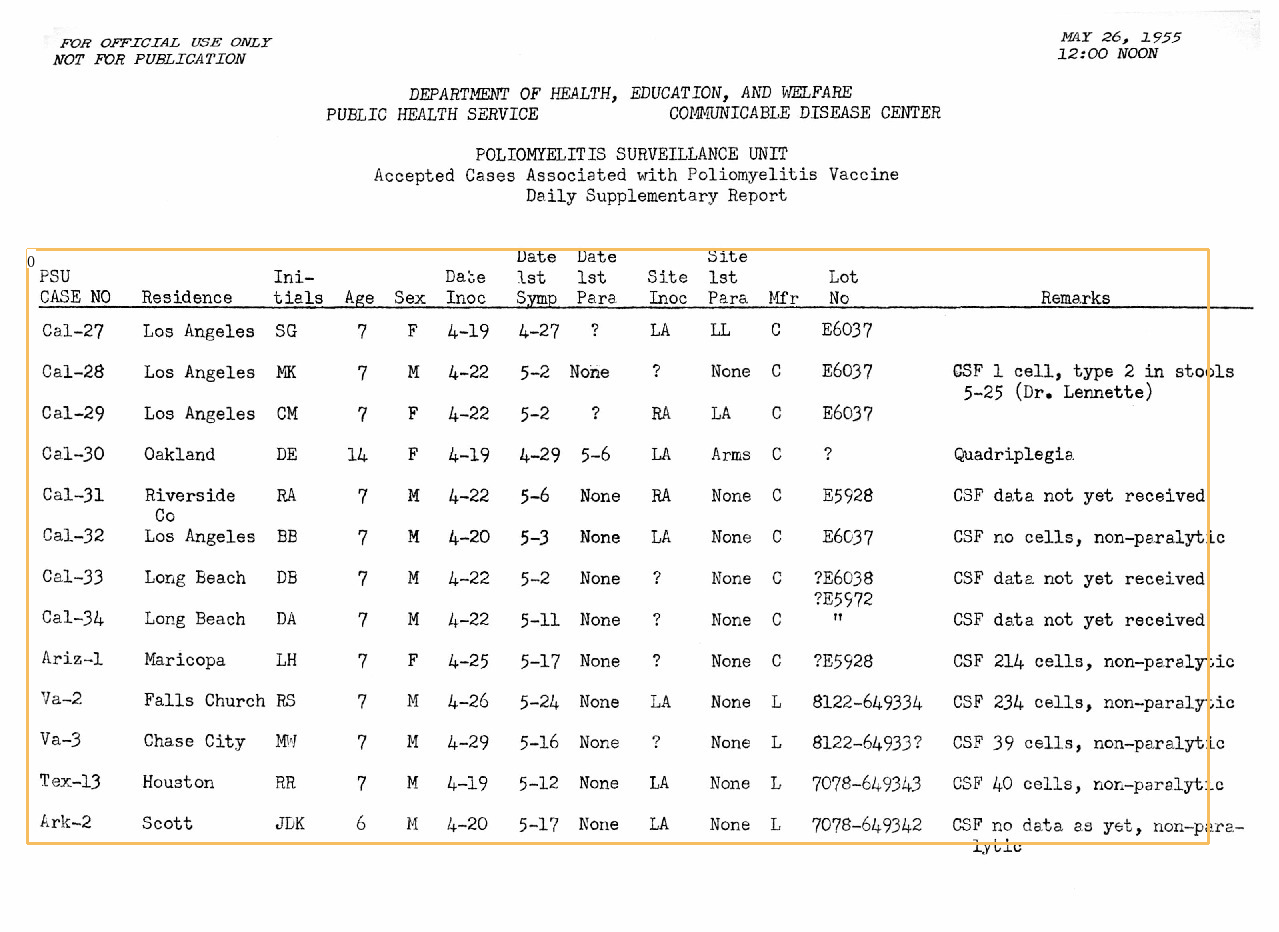

In [10]:
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

In [11]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

In [12]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [13]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [14]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

 

Date Date Site
PSU Ini- Date Ast lst ist Lot
CASE NO Residence tials Age Sex Inoc Symp Para Para No Renarks
Cal-27 Los Angeles SG F419 4-27? LL £6037
Cal-28 Los Angeles MK M 4-22 5-2 None None 86037 GSF 1 cell, type 2 in stoc

5-25 (Dr. Lennette)

Cal-29 Los Angeles OM Fo 4-22 5-2 2? LA £6037
Cal-30 Oakland DE Fo o&e19 4-29 5-6 Arms 2 @uadriplegia
Cal-31 Riverside = RA 7 M 4-22 5-6 None None E5928 CSF data not yet received
Cal-32 ie Angeles BB 7 M 4-20 5-3. None None E6037 CSF no cells, non-peralyt;
Gel-33 Long Beach DB 7 M 4-22 5-2 None None 786038 CSF date not yet received
Cal-34 Long Beach DA 7 M 4-22 5-11 None None ei CSF data not yet received
Ariz-l Maricopa LH 7 F 4-25 5-17 None None 785928 CSF 214 cells, non-perelyt
Va-2 Falls Church RS 7 M 4-26 5-24 None None 8122-649334 CSF 23h cells, non~paralyt
Va-3 Chase City MY 7 Mo 4-29 5-16 None None 8122-64933? CSF 39 cells, non-paralyti
Tex-13 Houston RR 7 M 4-19 5-12 None None 7078-64.9343 CSF 40 cells, nor—parelyti
Ark~2 Scott DK 

In [15]:
text_blocks.get_texts()

[' \n\nDate Date Site\nPSU Ini- Date Ast lst ist Lot\nCASE NO Residence tials Age Sex Inoc Symp Para Para No Renarks\nCal-27 Los Angeles SG F419 4-27? LL £6037\nCal-28 Los Angeles MK M 4-22 5-2 None None 86037 GSF 1 cell, type 2 in stoc\n\n5-25 (Dr. Lennette)\n\nCal-29 Los Angeles OM Fo 4-22 5-2 2? LA £6037\nCal-30 Oakland DE Fo o&e19 4-29 5-6 Arms 2 @uadriplegia\nCal-31 Riverside = RA 7 M 4-22 5-6 None None E5928 CSF data not yet received\nCal-32 ie Angeles BB 7 M 4-20 5-3. None None E6037 CSF no cells, non-peralyt;\nGel-33 Long Beach DB 7 M 4-22 5-2 None None 786038 CSF date not yet received\nCal-34 Long Beach DA 7 M 4-22 5-11 None None ei CSF data not yet received\nAriz-l Maricopa LH 7 F 4-25 5-17 None None 785928 CSF 214 cells, non-perelyt\nVa-2 Falls Church RS 7 M 4-26 5-24 None None 8122-649334 CSF 23h cells, non~paralyt\nVa-3 Chase City MY 7 Mo 4-29 5-16 None None 8122-64933? CSF 39 cells, non-paralyti\nTex-13 Houston RR 7 M 4-19 5-12 None None 7078-64.9343 CSF 40 cells, nor—par

In [16]:
for block in text_blocks:
  print(block)

TextBlock(block=Rectangle(x_1=27.745519638061523, y_1=249.892578125, x_2=1208.8997802734375, y_2=843.3308715820312), text= 

Date Date Site
PSU Ini- Date Ast lst ist Lot
CASE NO Residence tials Age Sex Inoc Symp Para Para No Renarks
Cal-27 Los Angeles SG F419 4-27? LL £6037
Cal-28 Los Angeles MK M 4-22 5-2 None None 86037 GSF 1 cell, type 2 in stoc

5-25 (Dr. Lennette)

Cal-29 Los Angeles OM Fo 4-22 5-2 2? LA £6037
Cal-30 Oakland DE Fo o&e19 4-29 5-6 Arms 2 @uadriplegia
Cal-31 Riverside = RA 7 M 4-22 5-6 None None E5928 CSF data not yet received
Cal-32 ie Angeles BB 7 M 4-20 5-3. None None E6037 CSF no cells, non-peralyt;
Gel-33 Long Beach DB 7 M 4-22 5-2 None None 786038 CSF date not yet received
Cal-34 Long Beach DA 7 M 4-22 5-11 None None ei CSF data not yet received
Ariz-l Maricopa LH 7 F 4-25 5-17 None None 785928 CSF 214 cells, non-perelyt
Va-2 Falls Church RS 7 M 4-26 5-24 None None 8122-649334 CSF 23h cells, non~paralyt
Va-3 Chase City MY 7 Mo 4-29 5-16 None None 8122-64933? CS

In [ ]:

!pip install spacy

In [ ]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

     |████████████████████████████████| 51 kB 96 kB/s 
     |████████████████████████████████| 451 kB 28.3 MB/s 
     |████████████████████████████████| 6.0 MB 63.6 MB/s 
     |████████████████████████████████| 3.4 MB 56.8 MB/s 
     |████████████████████████████████| 1.1 MB 48.1 MB/s 
     |████████████████████████████████| 10.1 MB 36.1 MB/s 
     |████████████████████████████████| 181 kB 47.1 MB/s 
     |████████████████████████████████| 628 kB 54.3 MB/s 
     |████████████████████████████████| 42 kB 947 kB/s 
     |████████████████████████████████| 67 kB 3.9 MB/s 
     |████████████████████████████████| 895 kB 50.9 MB/s 
     |████████████████████████████████| 3.3 MB 47.9 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.

In [ ]:
!pip install click==7.1.1

     |████████████████████████████████| 82 kB 751 kB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
black 21.4b2 requires click>=7.1.2, but you have click 7.1.1 which is incompatible.


In [ ]:
import spacy
nlp = spacy.load("en_core_web_trf")

In [ ]:
sentence=["".join(txt) for txt in text_blocks.get_texts()]

In [ ]:
".".join(sentence)

' \n\nDate Date Site\nPSU Ini- Date Ast lst ist Lot\nCASE NO Residence tials Age Sex Inoc Symp Para Para No Renarks\nCal-27 Los Angeles SG F419 4-27? LL £6037\nCal-28 Los Angeles MK M 4-22 5-2 None None 86037 GSF 1 cell, type 2 in stoc\n\n5-25 (Dr. Lennette)\n\nCal-29 Los Angeles OM Fo 4-22 5-2 2? LA £6037\nCal-30 Oakland DE Fo o&e19 4-29 5-6 Arms 2 @uadriplegia\nCal-31 Riverside = RA 7 M 4-22 5-6 None None E5928 CSF data not yet received\nCal-32 ie Angeles BB 7 M 4-20 5-3. None None E6037 CSF no cells, non-peralyt;\nGel-33 Long Beach DB 7 M 4-22 5-2 None None 786038 CSF date not yet received\nCal-34 Long Beach DA 7 M 4-22 5-11 None None ei CSF data not yet received\nAriz-l Maricopa LH 7 F 4-25 5-17 None None 785928 CSF 214 cells, non-perelyt\nVa-2 Falls Church RS 7 M 4-26 5-24 None None 8122-649334 CSF 23h cells, non~paralyt\nVa-3 Chase City MY 7 Mo 4-29 5-16 None None 8122-64933? CSF 39 cells, non-paralyti\nTex-13 Houston RR 7 M 4-19 5-12 None None 7078-64.9343 CSF 40 cells, nor—pare

In [ ]:
doc = nlp(".".join(sentence))
for ent in doc.ents:
  print(ent.text,ent.label_)

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 CARDINAL
2 CARDINAL
2 CARDINAL
785928 CARDINAL
214 CARDINAL


In [ ]:
#

#Detecting Titles,tables,Text,List and Figures

In [7]:
import layoutparser as lp

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2


In [18]:
image = cv2.imread("/content/layout-parser/examples/data/paper-image.jpg")
image = image[..., ::-1] 
    # Convert the image from BGR (cv2 default loading style)
    # to RGB

In [19]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', 
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
    # Load the deep layout model from the layoutparser API 
    # For all the supported model, please check the Model 
    # Zoo Page: https://layout-parser.readthedocs.io/en/latest/notes/modelzoo.html

config.yml?dl=1: 8.19kB [00:01, 8.00kB/s]
model_final.pth?dl=1: 330MB [00:08, 37.6MB/s]
The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [20]:
layout = model.detect(image)
    # Detect the layout of the input image

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


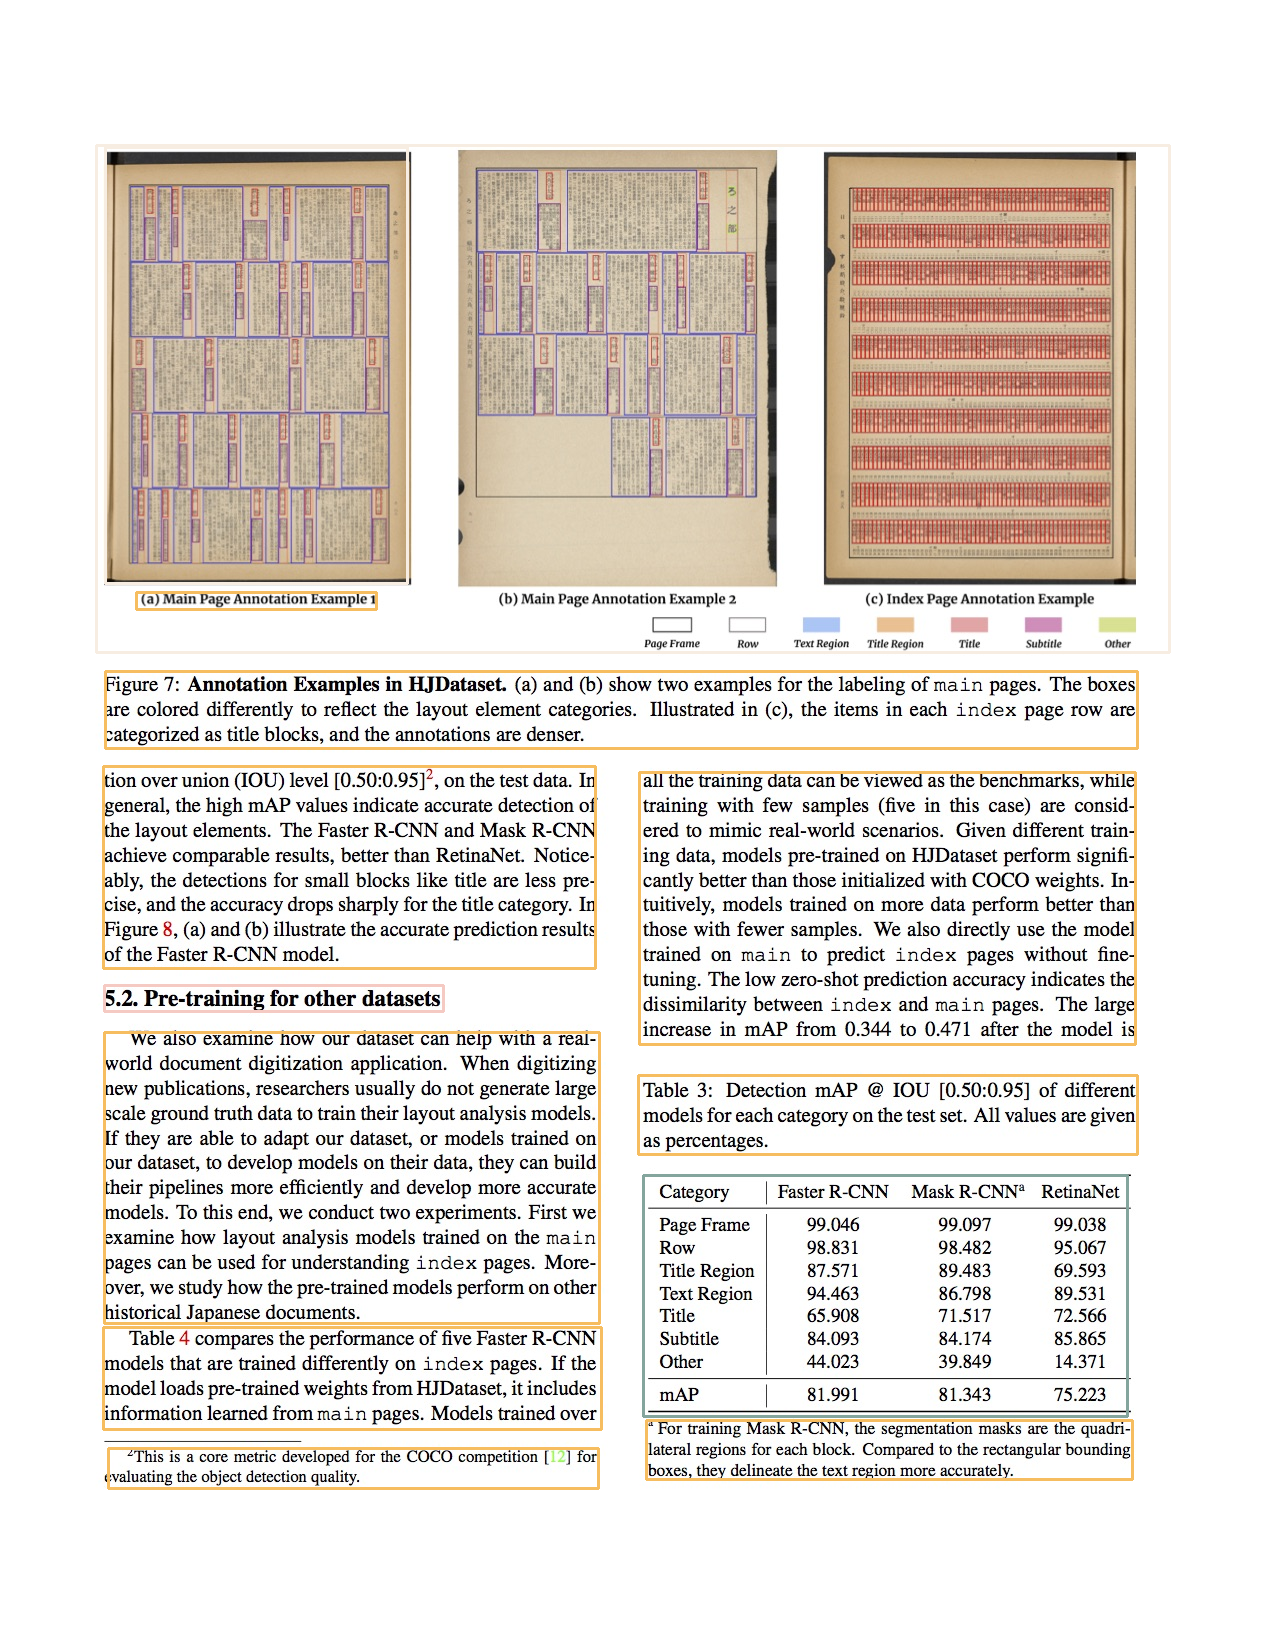

In [21]:
lp.draw_box(image, layout, box_width=3)
    # Show the detected layout of the input image

In [22]:
#check results from the model
type(layout)

layoutparser.elements.layout.Layout

In [23]:
layout[0]

TextBlock(block=Rectangle(x_1=646.4181518554688, y_1=1420.1715087890625, x_2=1132.86865234375, y_2=1479.7222900390625), text=None, id=None, type=Text, parent=None, next=None, score=0.9996440410614014)

In [38]:
#using coordinate system to process the detected layout
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])
title_blocks=lp.Layout([b for b in layout if b.type=='Title'])

In [25]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [26]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
# The b.coordinates[1] corresponds to the y coordinate of the region
# sort based on that can simulate the top-to-bottom reading order 
right_blocks = lp.Layout([b for b in text_blocks if b not in left_blocks])
right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

# And finally combine the two lists and add the index
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

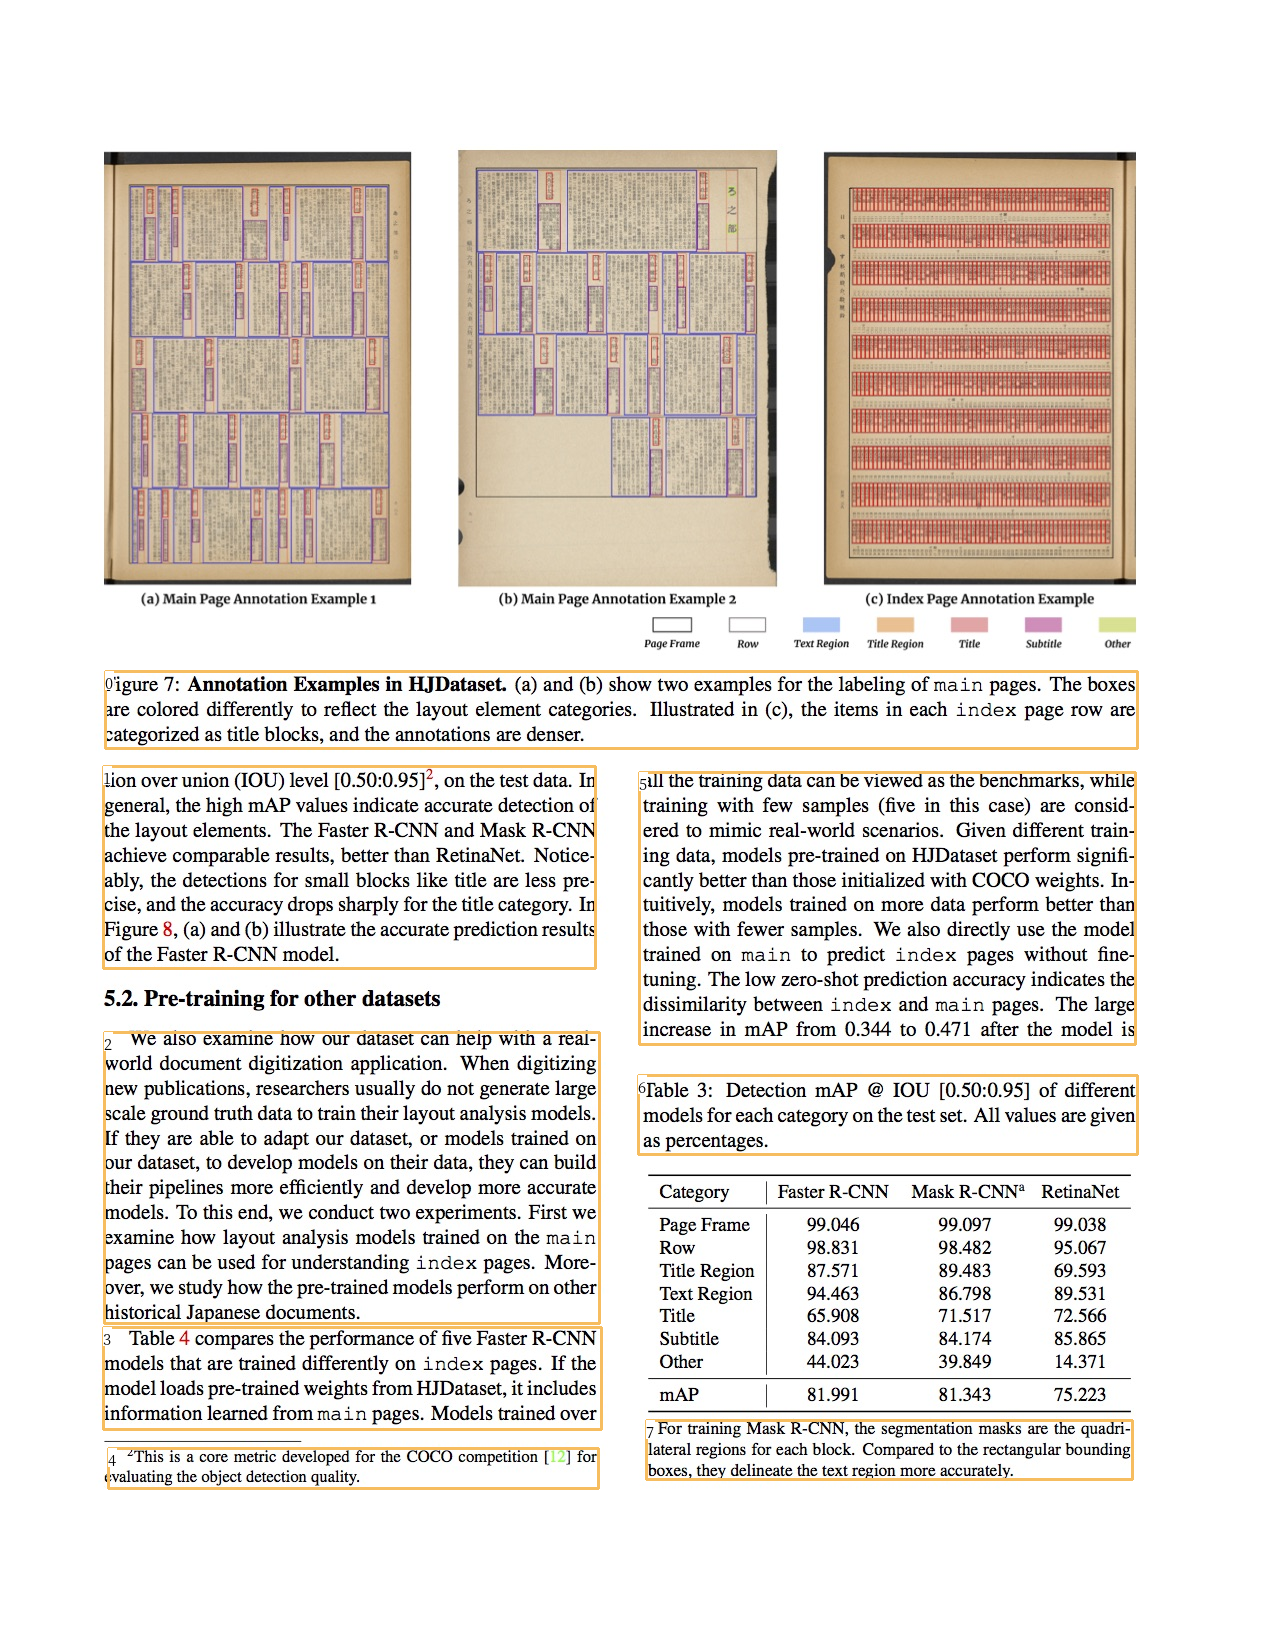

In [28]:
lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

In [29]:
ocr_agent = lp.TesseractAgent(languages='eng') 
    # Initialize the tesseract ocr engine. You might need 
    # to install the OCR components in layoutparser:
    # pip install layoutparser[ocr]

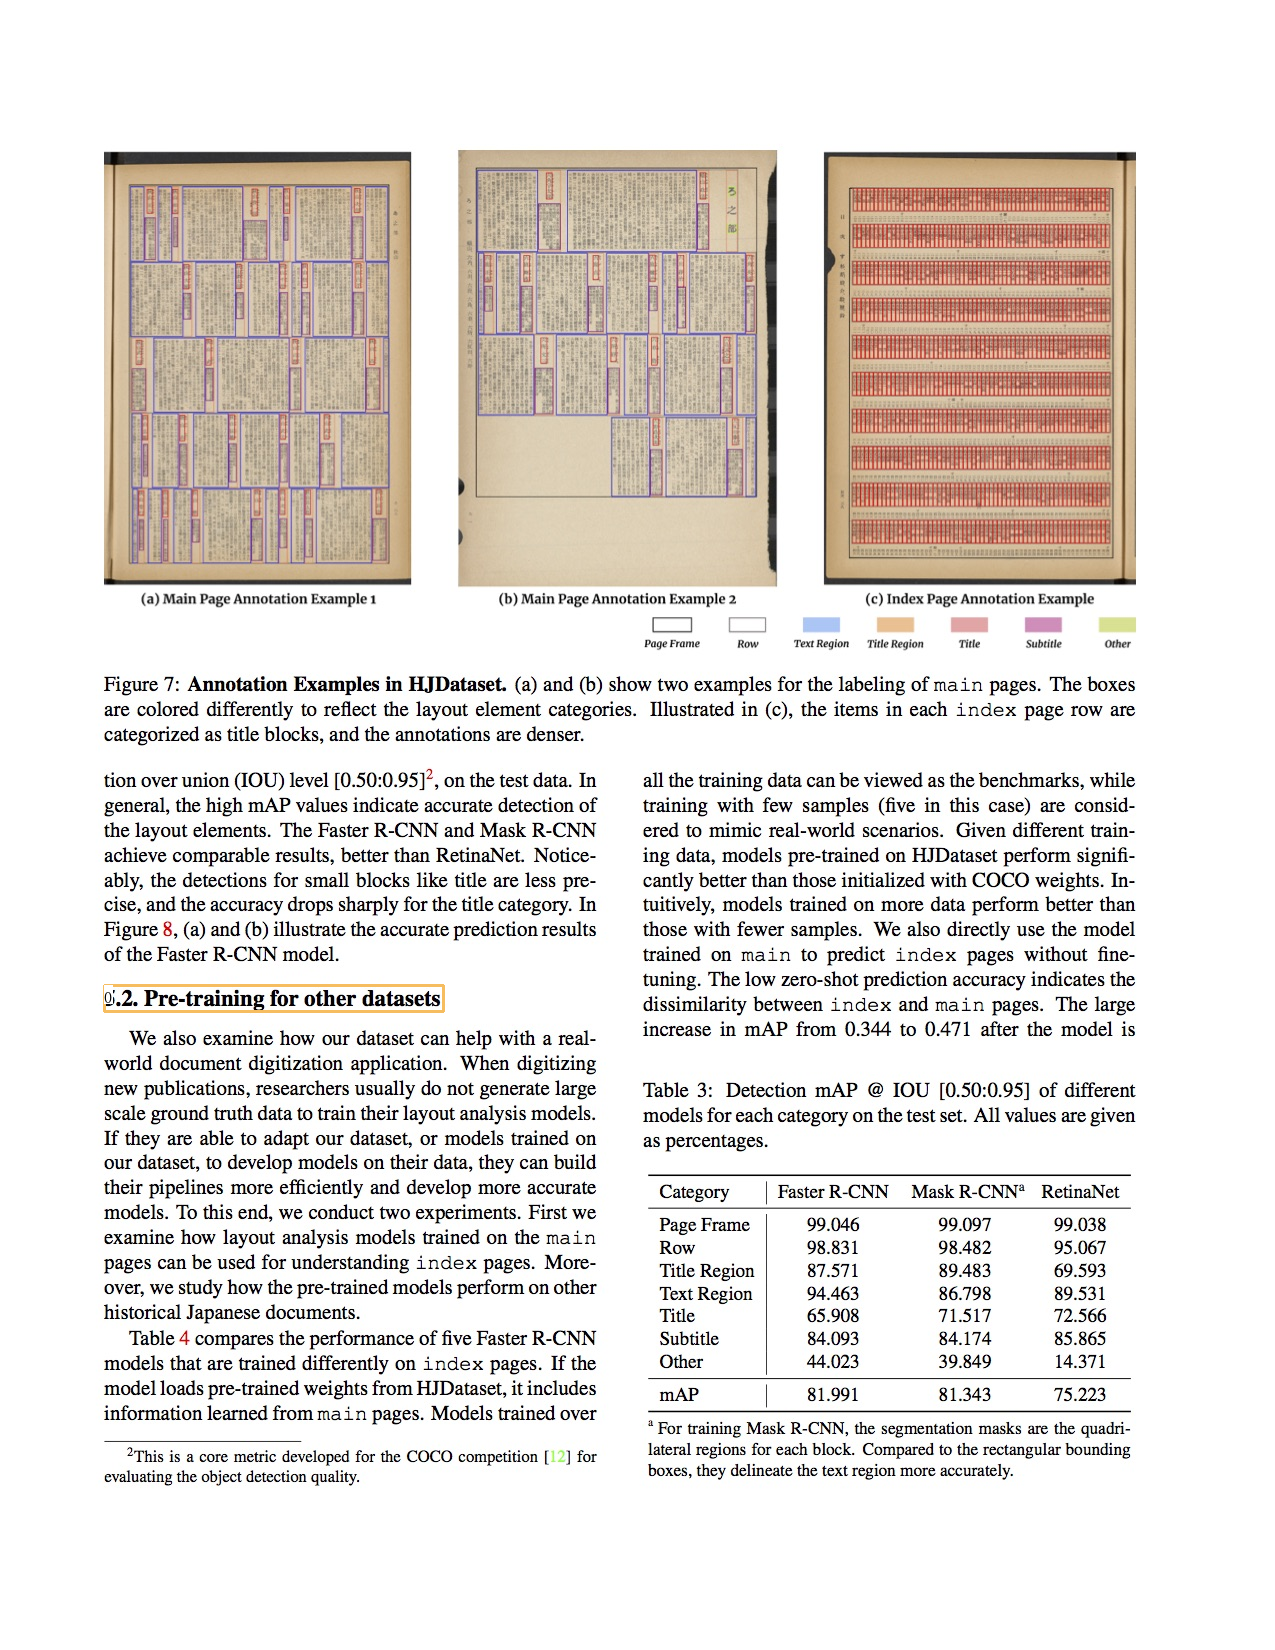

In [39]:
lp.draw_box(image, title_blocks,
            box_width=3, 
            show_element_id=True)

In [44]:
for block in title_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)
    for title in title_blocks.get_texts():
    
        print(title,end='\n')

5.2. Pre-training for other datasets



# New Section

# paragraphs

In [30]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [34]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

Figure 7: Annotation Examples in HJDataset. (a) and (b) show two examples for the labeling of main pages. The boxes
are colored differently to reflect the layout element categories. Illustrated in (c), the items in each index page row are
categorized as title blocks, and the annotations are denser.

---
tion over union (IOU) level [0.50:0.95]’, on the test data. In
general, the high mAP values indicate accurate detection of
the layout elements. The Faster R-CNN and Mask R-CNN
achieve comparable results, better than RetinaNet. Notice-
ably, the detections for small blocks like title are less pre-
cise, and the accuracy drops sharply for the title category. In
Figure 8, (a) and (b) illustrate the accurate prediction results
of the Faster R-CNN model.

---
  

We also examine how our dataset can help with
world document digitization application. When digitizing
new publications, researchers usually do not generate large
scale ground truth data to train their layout analysis models.
If t

In [37]:
for txt in text_blocks.get_texts():
    with open('outfile.txt','w') as of :
         of.write(txt)